# Analysis for Figure 5 
#### Last updated 2023-05-08

This notebook contains code to generate figures 5A,B,C,D in [Lotthammer, Ginell, Griffith et al.](https://www.biorxiv.org/content/10.1101/2023.05.08.539824v1)

In [6]:
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
	
# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.5

# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'

# set font type/weight
font = {'family' : 'arial',
    	'weight' : 'normal'}

matplotlib.rc('font', **font)
import random

from matplotlib.backends.backend_pdf import PdfPages

In [3]:
# import Protein from sparrow for calculations
from sparrow import Protein
from sparrow.data.amino_acids import VALID_AMINO_ACIDS 

# import create from goose
from goose import create



### Local function definitions 
Below we define some local functions used in this notebook.

In [2]:
def residue_selector(inlist, total_frac):
    """
    Function which lets you generate a dictionary which amino acid
    identity back to fraction of amino acids (adding up to total_frac)
    The idea is this gives you a way to pass in a list of amino acids
    and return a randomly selected set of fractions which add up to 
    the total.
    
    This is useful if you want (say) 0.4 of your sequence to be made 
    up of multiple residue types but you don't care which ones, particularly.
    
    We will expand this functionality into GOOSE at some point.
    
    Parameters
    --------------
    inlist : list
        List of amino acids
        
    total_fract : float
        Total fraction you want the amino acids in inlist to add up to
        
        
    Returns
    --------------
    dict 
        Dictionary where keys are the amino acids in inlist and values
        are fractions that should add up to total_fract
    
    """
    vals = {}
    np.random.shuffle(inlist)
    while len(inlist) > 1:
        s = inlist.pop()
        vals[s] = np.random.uniform(0, total_frac)
        total_frac = total_frac - vals[s]
        
    # we do -0.01 to avoid GOOSE freaking out
    vals[inlist[0]] = np.max([total_frac-0.001, 0])
        
    return vals

    

## Fig 5A (Das plot)
First figure in figure 5.

This should take 10-15 minutes to run on a modern computer using only CPU functionality. Note we're predicting Rgs for 43,050 different sequences in this cell (!) by default. In series on a CPU!


In [4]:

# figure uses a stepsize of 0.025 in fp/fn space
residue_fraction = np.arange(0,1.05, 0.025)

# number of random sequence we generate per quadrant [figure use 50]
n_seqs = 50

# length of the sequence [figure uses 100]
seq_len = 100

# initialize empty lists
all_fp = []
all_fn = []
all_rg = []

das_titration = []
for fp in residue_fraction:    
    for fn in residue_fraction:    
        tmp = []
        
        # only complete for valid combinations of fp/fn
        if fp + fn <= 1:

            for r in range(n_seqs):
                
                # creates a dictionary that maps fraction of R and K
                # so both add up to fp (fraction positive)
                d1 = residue_selector(['R','K'], fp)
                
                # update that dictionary with fractions of E and D so
                # these also add up to fn (fraction negative)
                d1.update(residue_selector(['E','D'], fn))
                
                # create a random disordered sequence of 100 residues
                # with the specified amino acid composition in terms R/K/E/D
                s = create.seq_fractions(100, **d1)
                
                # add that sequences Rg onto the list of Rg
                tmp.append(Protein(s).predictor.radius_of_gyration())
                
            # fnally updated the master lists that map fraction positive,
            # fraction negative, and average Rg for the n_seqs with the designated
            # fp and fn composition
            all_fp.append(fp)
            all_fn.append(fn)
            all_rg.append(np.mean(tmp))
        


### Generate Fig. 5a
Then, having calculated these Rgs we generate a figure using matplotlib and save under
the `/figures` directory

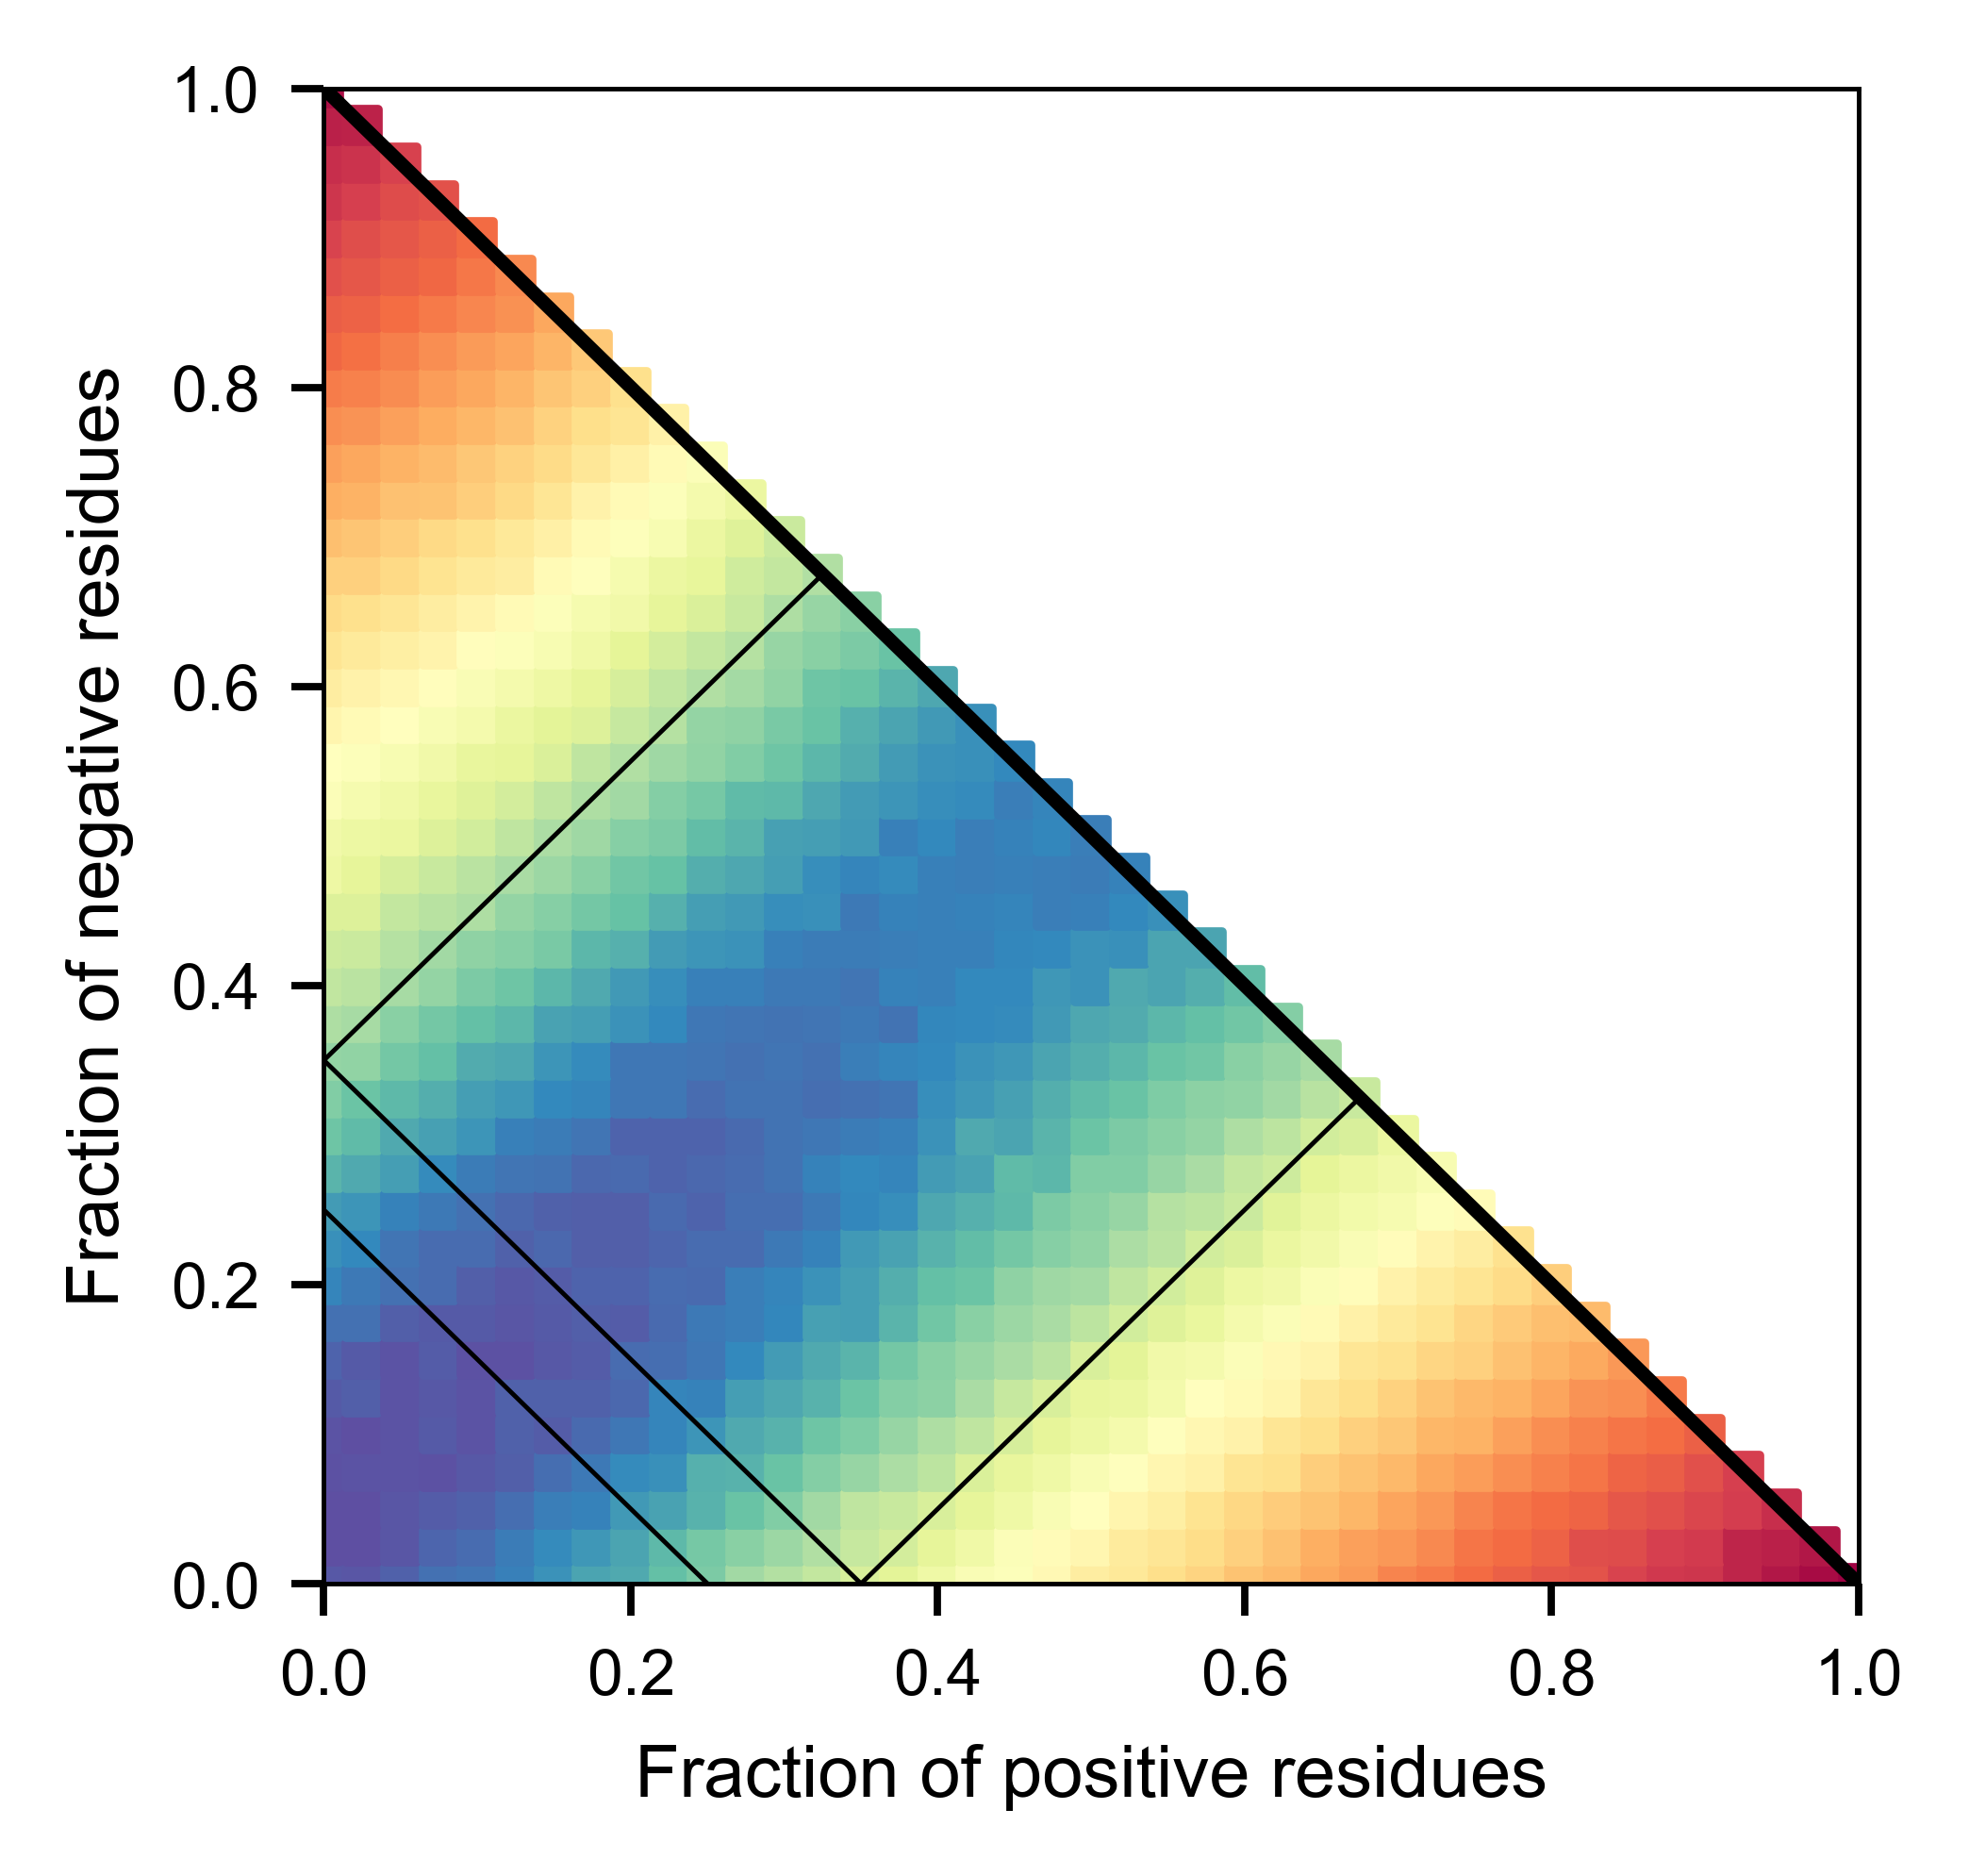

In [7]:
#
fig = figure(None, (3,3), dpi=350)

# we're doinga hack to create a psuedo-heatmap using colored squares plotted as a 
# systematic scatter plot
plt.scatter(all_fp, all_fn, c=all_rg,s=12,marker='s', cmap='Spectral_r', rasterized=True)

# set x/y lims
plt.ylim([0,1])
plt.xlim([0,1])

# draw on lines that make up the diagram of states as defined by Das & Pappu
plt.plot([0.25, 0.0],[0.0,0.25],'-k',linewidth=0.5)
plt.plot([0.35, 0.0],[0.0,0.35],'-k',linewidth=0.5)
plt.plot([0.0, 0.325],[0.35,0.675],'-k',linewidth=0.5)
plt.plot([0.35, 0.675],[0.0,0.325],'-k',linewidth=0.5)
plt.plot([0, 1],[1, 0.0],'-k',linewidth=1.5)

plt.xlabel('Fraction of positive residues', fontsize=8)
plt.ylabel('Fraction of negative residues', fontsize=8)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)

# uncomment 
#plt.colorbar()

# do this so we get a high-res fugure where scattered data is still rasterized
with PdfPages('figures/das_pappu.pdf') as pdf:
    pdf.savefig(fig, dpi=950)


## Fig 5B (NCPR vs. Rg)
Next we generate the NCPR figure.

In [9]:
# here up the number of sequences to 100
n_seqs = 100

# here set the sequence length again to 100
seq_len = 100

# slightly more granular NCPR titration 
ncpr_range = np.arange(-0.8,0.85,0.1)

# initialize empty list of RGs
ncpr_rg = []

# for the range of NCPRs
for local_ncpr in ncpr_range:
    tmp = []
    for idx in range(n_seqs):        
        
        # create a random IDR with the specified NCPR
        s = create.sequence(seq_len, NCPR=local_ncpr)
        
        # add that IDRs Rg
        tmp.append(Protein(s).predictor.radius_of_gyration())
        
    # note tmp here is a list of Rgs, so we're saving them all
    ncpr_rg.append(tmp)
    
        





### Fig 5B (NCPR vs. Rg)
Next we generate a version of 5B with individual datapoints plotted; this doesn't actually
go in the paper but useful to see how tight the distribution actually is!

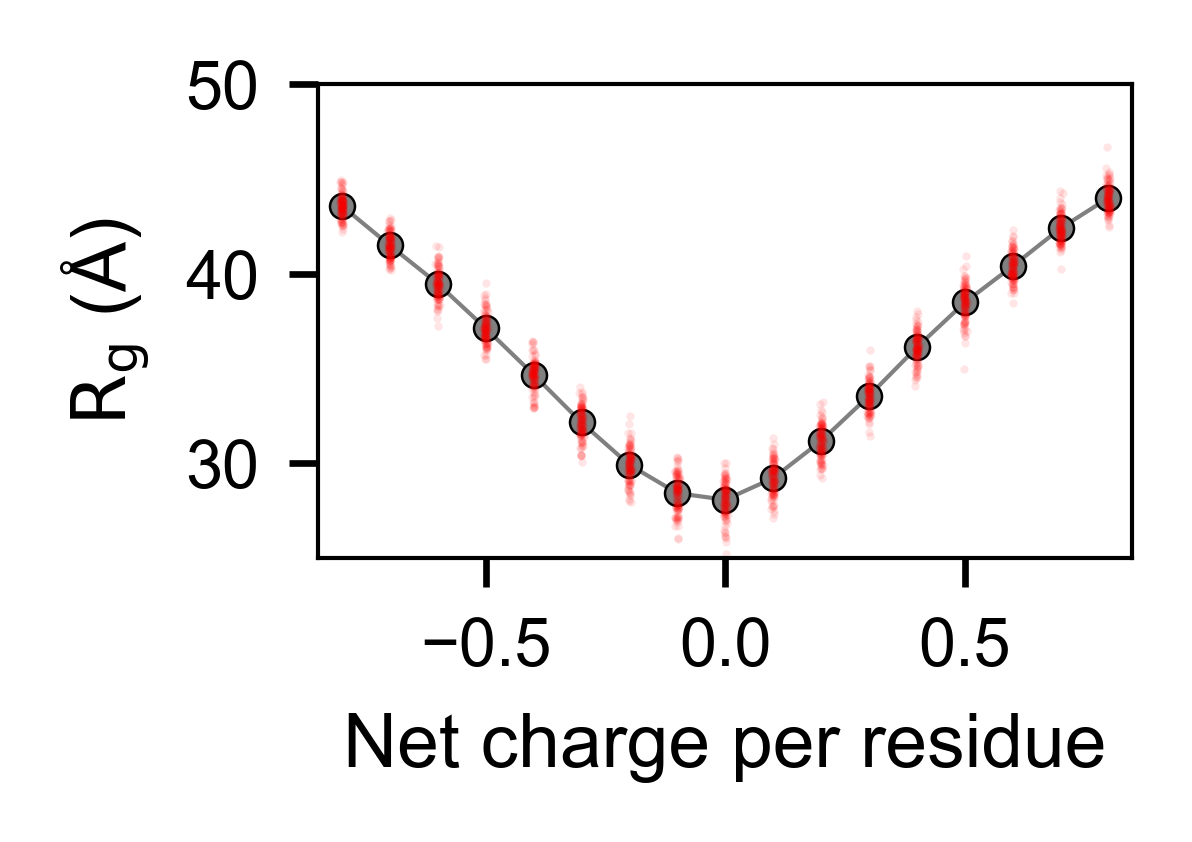

In [10]:
plt.figure(figsize = (2.1,1.5), dpi = 300)

n_datapoints = len(ncpr_range)

plt.plot(ncpr_range, [np.mean(x) for x in ncpr_rg], 'o-', color='grey',linewidth=0.5, ms=3, mec='k',mew=0.3)
for i in range(n_datapoints):

    xvals = np.random.normal(ncpr_range[i], 0.002, size=len(ncpr_rg[i]))

    plt.plot(xvals, ncpr_rg[i],'.', ms=2., mew=0, alpha=0.1, color='r')
    

plt.ylim([25,50])
plt.xlim([-0.85,0.85])

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel('Net charge per residue', fontsize=9)
plt.ylabel(r'$\rm{R_g}$' +' (Å)',fontsize=9)
plt.tight_layout()
plt.savefig('figures/NCPR_with_individual_seqs.pdf')

Finally - generate figure we actually use.

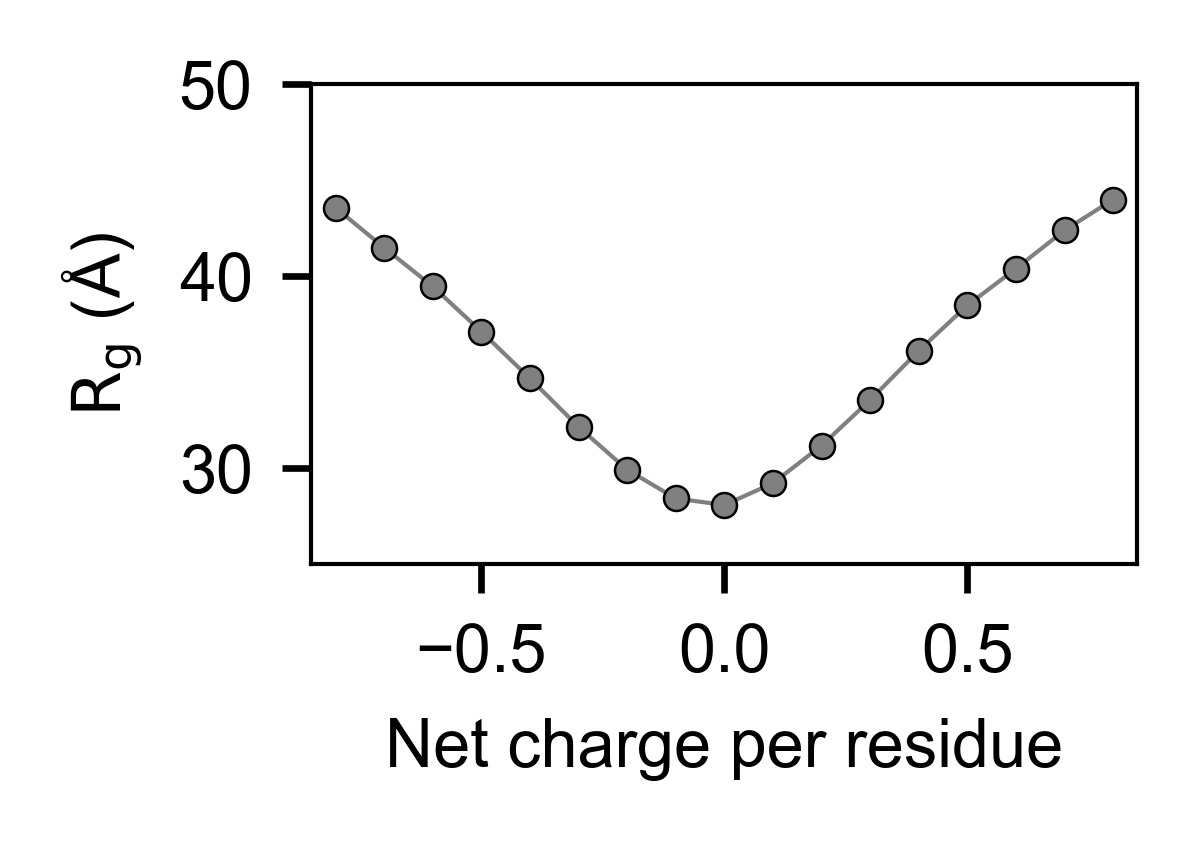

In [11]:
# also generate a version which we use in the figure
plt.figure(figsize = (2.1,1.5), dpi = 300)

plt.plot(ncpr_range, [np.mean(x) for x in ncpr_rg], 'o-', color='grey',linewidth=0.5, ms=3, mec='k',mew=0.3)
plt.ylim([25,50])
plt.xlim([-0.85,0.85])
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel('Net charge per residue', fontsize=8)
plt.ylabel(r'$\rm{R_g}$' +' (Å)',fontsize=8)
plt.tight_layout()
plt.savefig('figures/NCPR.pdf')

### Fig 5C (kappa vs. FCR)
Next we generate the data for exploring kappa vs. FCR (Fig 5C). Note in our final version the kappa values range from 0.05 to 0.75 (!) so those highly compact sequences are VERY segregated!

This should take 3-5 min to run.

In [16]:
# again, generate 100 seqs per unique combination of FCR and kappa
n_seqs = 100

# set kappa range here - note we take quite big steps in kappa space 
# to avoid the figure being too croweded
kappa_range = np.arange(0.05, 0.8, 0.1)

# we take smaller steps in FCR space
fcr_range = np.arange(0.1, 0.8, 0.05)

# alll kappa sequs will be a nested list where each sublist contains 
# a set of average Rgs for a given kappa value as a function of FCR
all_kappa_seqs = []
for kappa in kappa_range:
    print(kappa)
    local = []
    
    for fcr in fcr_range:
        tmp = []
        for i in range(n_seqs):
            tmp.append(Protein(create.sequence(100, NCPR=0, FCR=fcr, kappa=kappa)).predictor.radius_of_gyration())
        local.append(np.mean(tmp))
    all_kappa_seqs.append(local)
            
        
    
    
    

0.05
0.15000000000000002
0.25000000000000006
0.35000000000000003
0.45000000000000007
0.5500000000000002
0.6500000000000001
0.7500000000000002


### Fig 5C (kappa vs. FCR)
Finally we actually generate the plot, note the colors for the different kappa sequences chosen were manually selected to titrate across grey to red and are defined here.

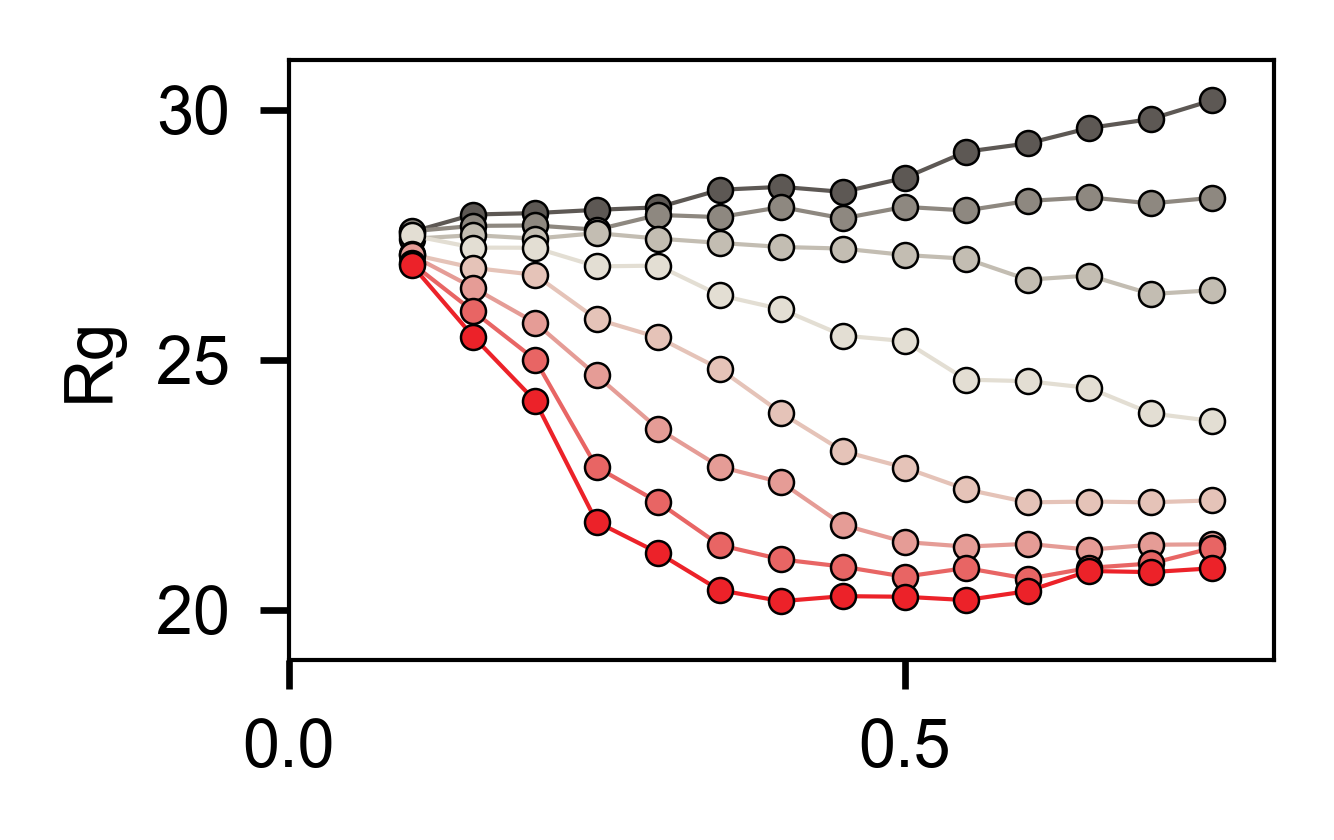

In [18]:
kappa_colors = ['#ec2229', '#e86564', '#e59c96', '#e5c3b8', '#e3ded3', '#c3bdb2', '#8e8880', '#5d5854'][::-1]

plt.figure(figsize = (2.4,1.5), dpi = 300)
idx=0
for i in list(range(0,8)):
    plt.plot(fcr_range, all_kappa_seqs[i], 'o-',  color=kappa_colors[idx], linewidth=0.5, ms=3, mec='k',mew=0.3)
    idx=idx+1

plt.ylim([19,31])
plt.xlim([0,0.8])
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.ylabel('Rg',fontsize=8)
plt.tight_layout()
plt.savefig('figures/kappa_variants.pdf')


## Compute fractional-dependence 
The cell below calculates the fractional dependence from 0 up to 0.4 for each of the 20 amino acids. This means we're calculating proteins for about 40,000 IDRs, which again should take 10-15 minutes on a serialized CPU.

To track progress, the cell prints out the current amino acid!

In [21]:
aa_fractions = np.arange(0,0.42,0.02)
n_seqs = 100

return_data = {}
for aa in VALID_AMINO_ACIDS:
    print(aa)
    
    local_titration = []
    for fract in aa_fractions:

        tmp = []
        for s in range(n_seqs):
            tmp.append(Protein(create.seq_fractions(100, **{aa:fract, 'max_aa_fractions':{aa:1}, 'cutoff':0.0}, )).predictor.radius_of_gyration())
            
        local_titration.append(np.mean(tmp))
        
    return_data[aa] = local_titration
    
    

A
C
D
E
F
G
H
I
K
L
M
N
P
Q
R
S
T
V
W
Y


### Generate Figures for panel D

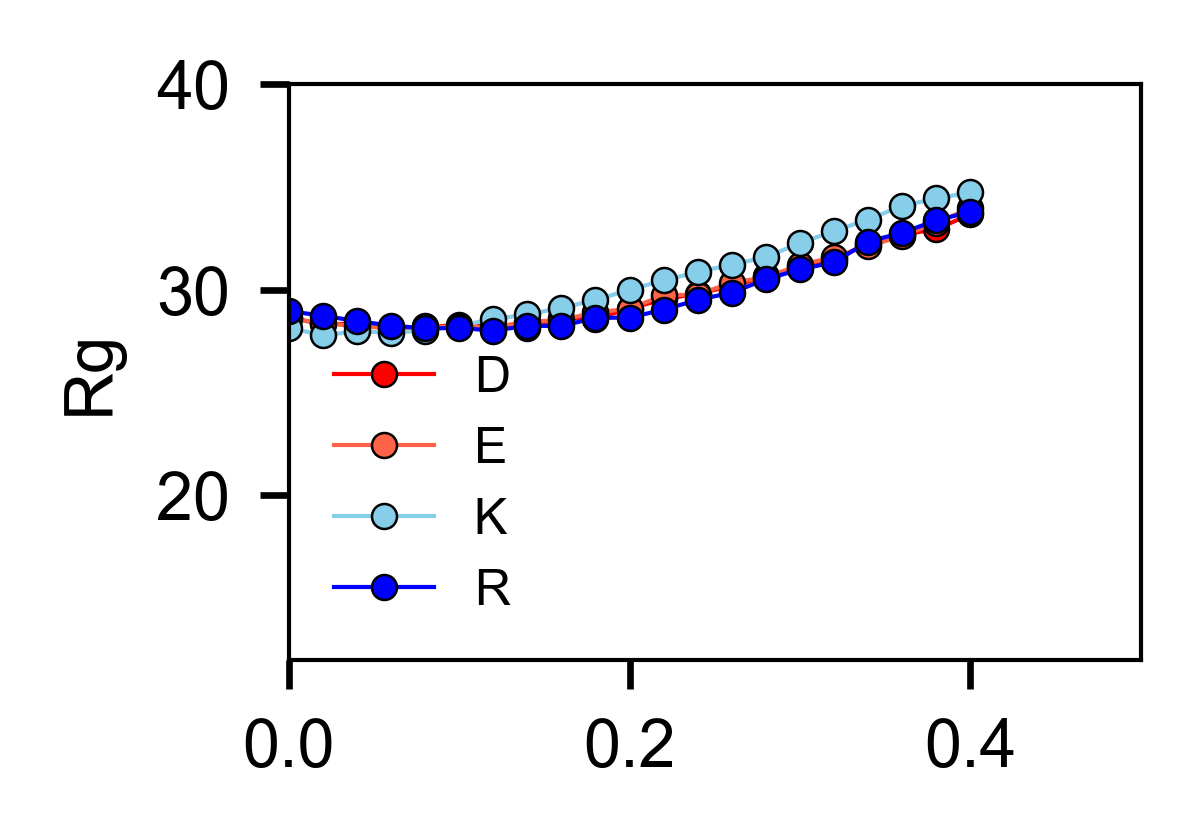

In [22]:
# charge residues - not include but here for completeness
plt.figure(figsize = (2.1,1.5), dpi = 300)
plt.plot(aa_fractions, return_data['D'], 'o-', label='D', color='red', linewidth=0.5, ms=3, mec='k',mew=0.3)
plt.plot(aa_fractions, return_data['E'], 'o-', label='E', color='tomato', linewidth=0.5, ms=3, mec='k',mew=0.3)
plt.plot(aa_fractions, return_data['K'], 'o-', label='K', color='skyblue', linewidth=0.5, ms=3, mec='k',mew=0.3)
plt.plot(aa_fractions, return_data['R'], 'o-', label='R', color='blue', linewidth=0.5, ms=3, mec='k',mew=0.3)
plt.legend(fontsize=6,frameon=False)
plt.ylim([12,40])
plt.xlim([0,0.5])
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.ylabel('Rg',fontsize=8)
plt.tight_layout()
plt.savefig('figures/charge_residues.pdf')


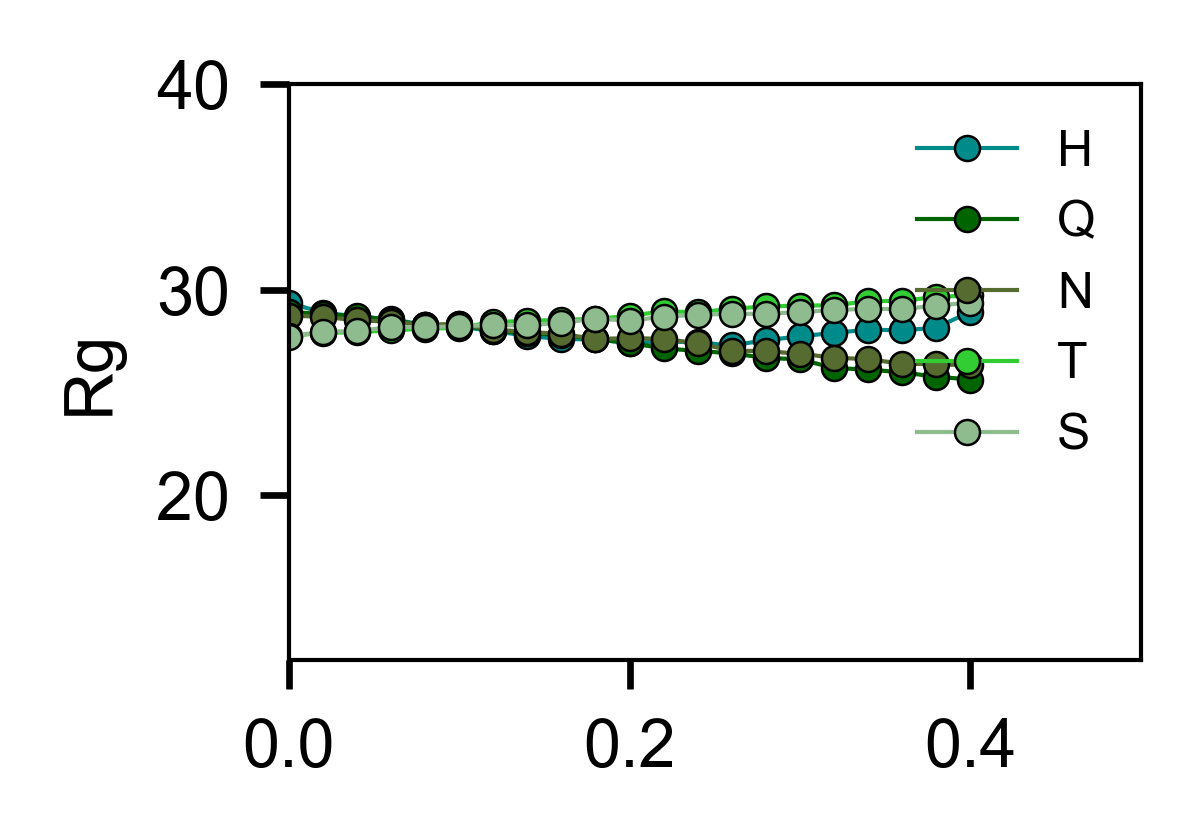

In [23]:
plt.figure(figsize = (2.1,1.5), dpi = 300)
plt.plot(aa_fractions, return_data['H'], 'o-',  label='H', color='darkcyan', linewidth=0.5, ms=3, mec='k',mew=0.3)
plt.plot(aa_fractions, return_data['Q'], 'o-',  label='Q', color='darkgreen',linewidth=0.5, ms=3, mec='k',mew=0.3)
plt.plot(aa_fractions, return_data['N'], 'o-',  label='N', color='darkolivegreen',linewidth=0.5, ms=3, mec='k',mew=0.3)
plt.plot(aa_fractions, return_data['T'], 'o-',  label='T', color='limegreen',linewidth=0.5, ms=3, mec='k',mew=0.3)
plt.plot(aa_fractions, return_data['S'], 'o-',  label='S', color='darkseagreen',linewidth=0.5, ms=3, mec='k',mew=0.3)
plt.legend(fontsize=6,frameon=False)
plt.ylim([12,40])
plt.xlim([0,0.5])
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.ylabel('Rg',fontsize=8)
plt.tight_layout()
plt.savefig('figures/polar_residues.pdf')

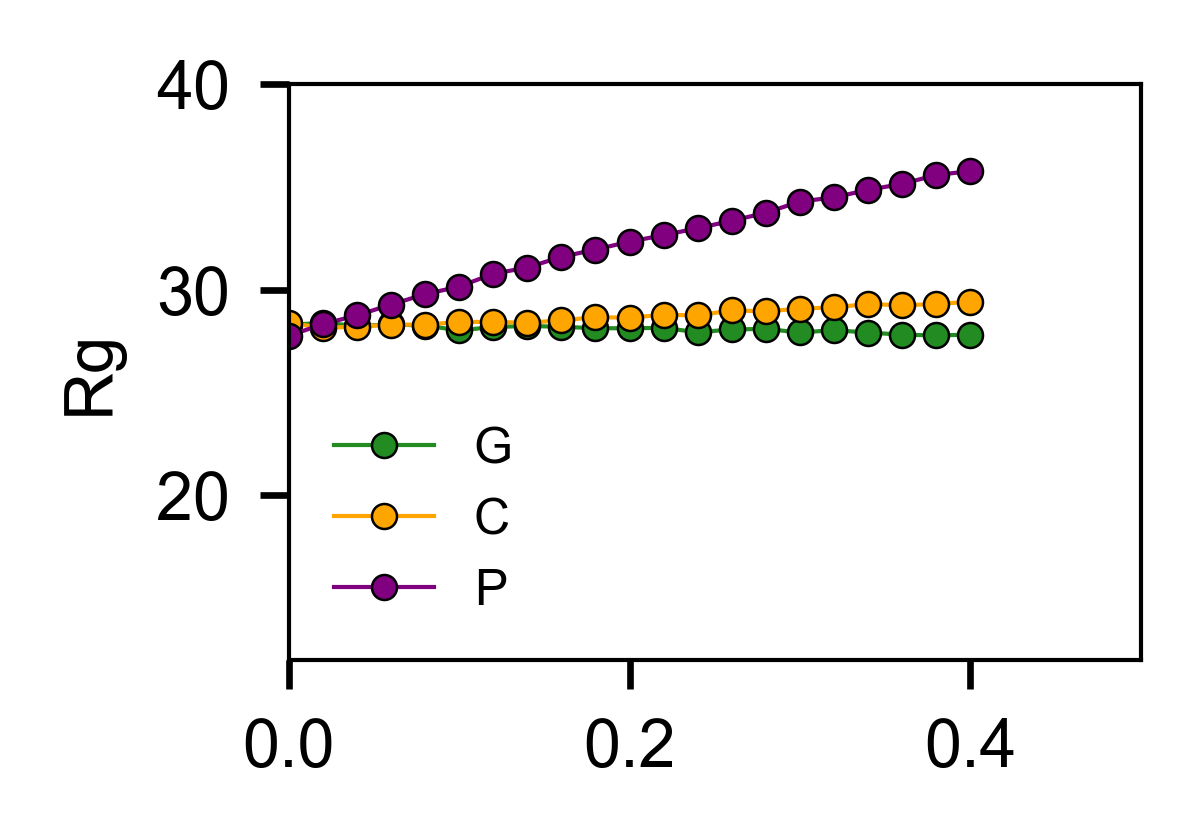

In [24]:
plt.figure(figsize = (2.1,1.5), dpi = 300)
plt.plot(aa_fractions, return_data['G'], 'o-',  label='G', color='forestgreen', linewidth=0.5, ms=3, mec='k',mew=0.3)
plt.plot(aa_fractions, return_data['C'], 'o-',  label='C', color='orange', linewidth=0.5, ms=3, mec='k',mew=0.3)
plt.plot(aa_fractions, return_data['P'], 'o-',  label='P', color='purple', linewidth=0.5, ms=3, mec='k',mew=0.3)
plt.legend(fontsize=6,frameon=False)
plt.ylim([12,40])
plt.xlim([0,0.5])
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.ylabel('Rg',fontsize=8)
plt.tight_layout()
plt.savefig('figures/outlier_residues.pdf')

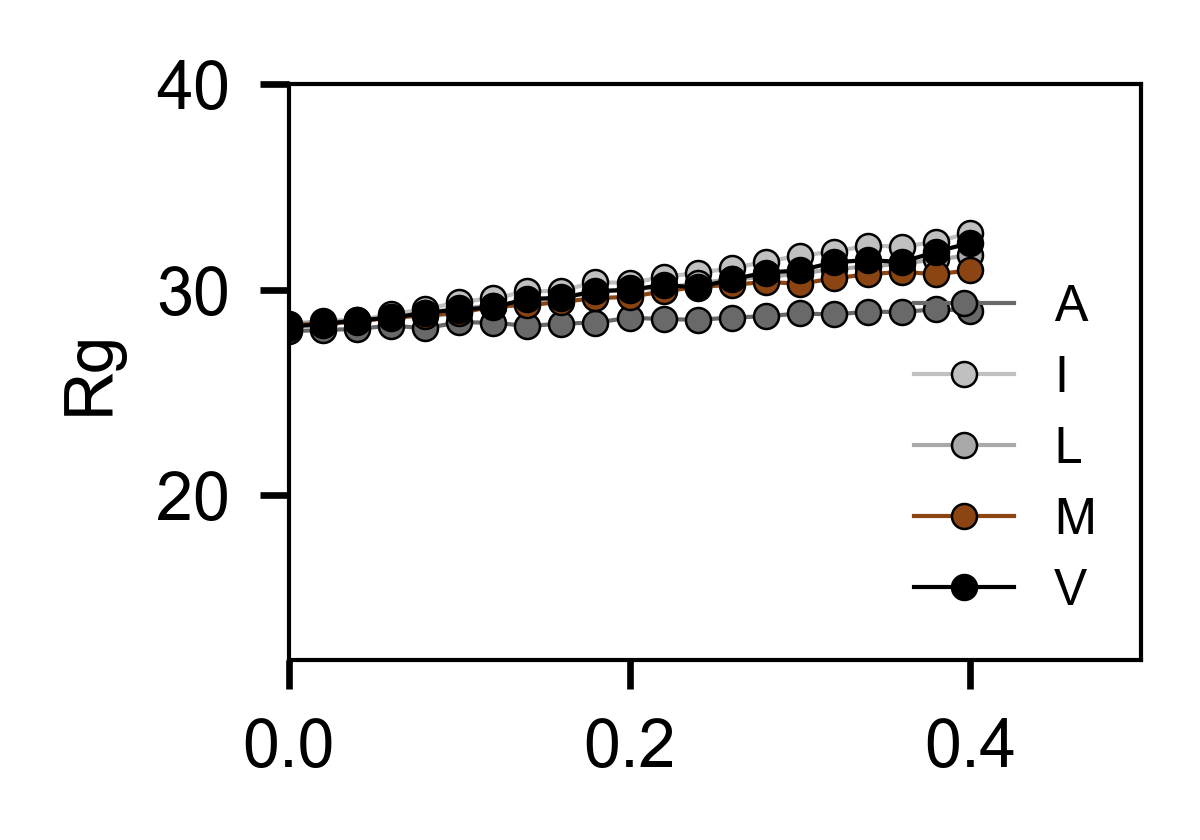

In [25]:
plt.figure(figsize = (2.1,1.5), dpi = 300)
plt.plot(aa_fractions, return_data['A'], 'o-',  label='A', color='dimgrey', linewidth=0.5, ms=3, mec='k',mew=0.3)
plt.plot(aa_fractions, return_data['I'], 'o-',  label='I', color='silver',linewidth=0.5, ms=3, mec='k',mew=0.3)
plt.plot(aa_fractions, return_data['L'], 'o-',  label='L', color='darkgrey',linewidth=0.5, ms=3, mec='k',mew=0.3)
plt.plot(aa_fractions, return_data['M'], 'o-',  label='M', color='saddlebrown',linewidth=0.5, ms=3, mec='k',mew=0.3)
plt.plot(aa_fractions, return_data['V'], 'o-',  label='V', color='black',linewidth=0.5, ms=3, mec='k',mew=0.3)
plt.legend(fontsize=6,frameon=False)
plt.ylim([12,40])
plt.xlim([0,0.5])
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.ylabel('Rg',fontsize=8)
plt.tight_layout()
plt.savefig('figures/aliphatic_residues.pdf')

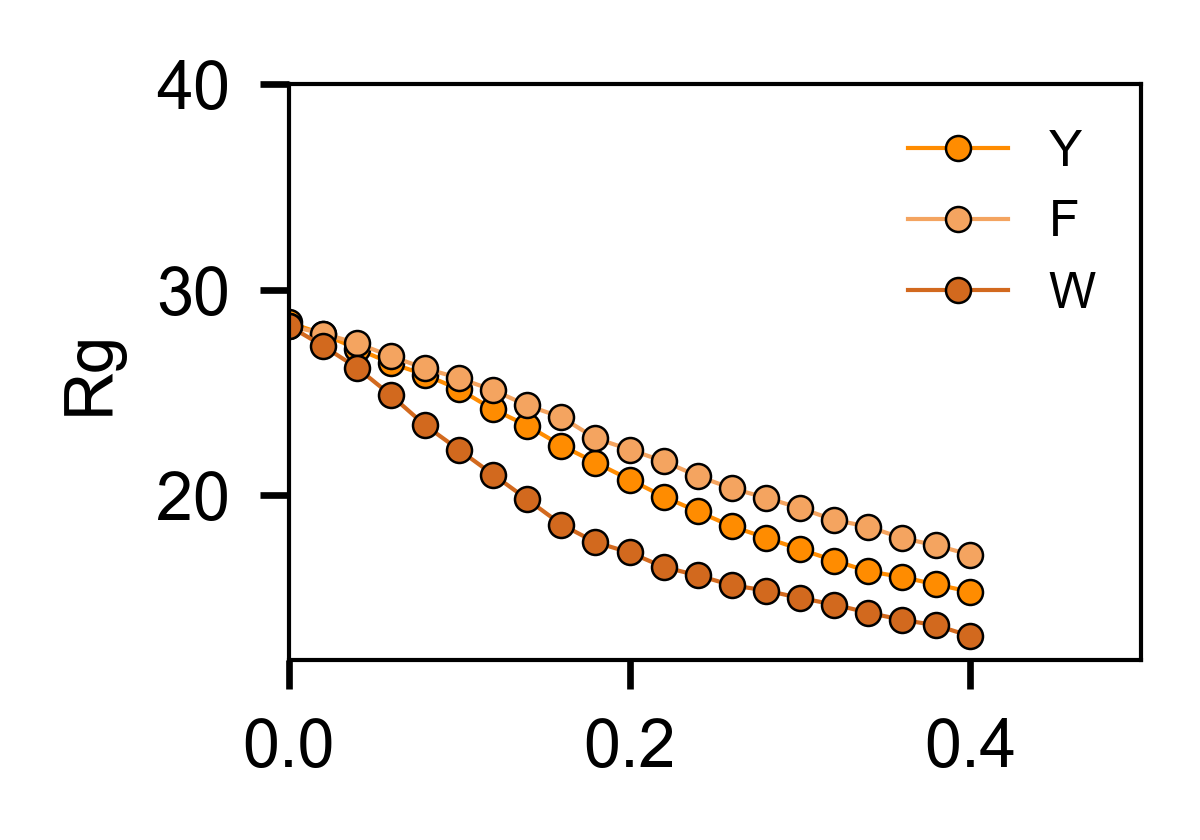

In [26]:
plt.figure(figsize = (2.1,1.5), dpi = 300)
plt.plot(aa_fractions, return_data['Y'], 'o-',  label='Y', color='darkorange', linewidth=0.5, ms=3, mec='k',mew=0.3)
plt.plot(aa_fractions, return_data['F'], 'o-',  label='F', color='sandybrown',linewidth=0.5, ms=3, mec='k',mew=0.3)
plt.plot(aa_fractions, return_data['W'], 'o-',  label='W', color='chocolate',linewidth=0.5, ms=3, mec='k',mew=0.3)
plt.legend(fontsize=6,frameon=False)
plt.ylim([12,40])
plt.xlim([0,0.5])
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.ylabel('Rg',fontsize=8)
plt.tight_layout()
plt.savefig('figures/aromatic_residues.pdf')